<a href="https://colab.research.google.com/github/smh997/Transactions-Results-Prediction/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import random


def preprocess(dataset: pd.DataFrame):
    """
    Preprocess dataset to be used for classification
    :param dataset: the given dataset
    :return: train dataset, target labels, data with in_progress label
    """

    # Checking lost values
    print(dataset.isnull().sum())

    # Feature creation -> Product_Mean_Date_Diff (Mean of DateDiff for different products)
    for product in dataset['Product'].unique():
        dataset.loc[(dataset['Product'] == product), 'Product_Mean_Date_Diff'] = dataset['DateDiff'].where(dataset['Product'] == product).sum() / ((dataset['Product'] == product).where(dataset['Deal_Stage'] == 'Won').sum())
    # Feature creation -> Win_Rate (Rate of won per sales agent)
    for agent in dataset['Sales_Agent'].unique():
        dataset.loc[(dataset['Sales_Agent'] == agent), 'Win_Rate'] = ((dataset['Deal_Stage'] == 'Won').where(dataset['Sales_Agent'] == agent).sum() / (dataset['Sales_Agent'] == agent).sum())

    # Modifying column DateDiff to be 1 if DateDiff is less than Product_Mean_Date_Diff or 0 otherwise
    for i in range(0, len(dataset)):
        if dataset.loc[i, 'DateDiff'] < dataset.loc[i, 'Product_Mean_Date_Diff']:
            dataset.loc[i, 'DateDiff'] = 1
        else:
            dataset.loc[i, 'DateDiff'] = 0
    # Renaming DateDiff after modifying
    dataset = dataset.rename(columns={'DateDiff': 'Early_accomplished'})

    # Separating train dataset (won and lost) and in_progress_dataset from main dataset
    train_dataset = dataset.copy()
    in_progress_dataset = train_dataset.loc[train_dataset.Deal_Stage == 'In Progress', train_dataset.columns]
    train_dataset = train_dataset.loc[train_dataset.Deal_Stage != 'In Progress', train_dataset.columns]

    # Resetting indices to work properly in next steps
    train_dataset.reset_index(drop=True, inplace=True)

    # Dropping unnecessary columns
    train_dataset = train_dataset.drop(
        ['Account', 'Opportunity_ID', 'Sales_Agent', 'SalesAgentEmailID', 'ContactEmailID', 'Created Date',
         'Close Date', 'Product_Mean_Date_Diff'], axis=1)
    in_progress_dataset = in_progress_dataset.drop(
        ['Account', 'Opportunity_ID', 'Sales_Agent', 'SalesAgentEmailID', 'ContactEmailID', 'Created Date',
         'Close Date', 'Product_Mean_Date_Diff'], axis=1)

    # Separating targets from train dataset
    targets = train_dataset['Deal_Stage']
    train_dataset = train_dataset.drop(['Deal_Stage'], axis=1)
    in_progress_dataset = in_progress_dataset.drop(['Deal_Stage'], axis=1)

    # One-Hot encoding the product feature as a categorical data
    train_dataset = train_dataset.join(pd.get_dummies(train_dataset['Product'])).drop('Product', axis=1)
    in_progress_dataset = in_progress_dataset.join(pd.get_dummies(in_progress_dataset['Product'])).drop('Product',
                                                                                                        axis=1)

    # Removing Outliers
    from scipy import stats
    z_scores = stats.zscore(train_dataset)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    train_dataset = train_dataset[filtered_entries]
    targets = targets[filtered_entries]

    # # Balancing data:
    # # Removing additional Won labeled data in random
    # size = len(train_dataset) - 1
    # won_indices = []
    # won_cnt = 0
    # remove_indices = []
    # for i, label in targets.items():
    #     if label == 'Won':
    #         won_indices.append(i)
    #         won_cnt += 1
    # lost_cnt = size - won_cnt
    # for i in range((won_cnt - lost_cnt)):
    #     r_index = random.randint(0, won_cnt - i - 1)
    #     remove_indices.append(won_indices[r_index])
    #     won_indices.pop(r_index)

    # train_dataset.drop(remove_indices, inplace=True, axis=0)
    # targets.drop(remove_indices, inplace=True, axis=0)

    return train_dataset, targets, in_progress_dataset


In [31]:
class KNearestNeighbors():
    """
    K-Nearest-Neighbors classifier
    """
    def __init__(self, k: int):
        """
        Initialize function
        :param k: k value
        """
        self.k = k
        self.X_train = None
        self.y_train = None
        self.feature_count = 0
        self.data_size = 0

    def fit(self, X_train, y_train):
        """
        Determining train data and their labels plus number of columns and rows
        :param X_train: train data
        :param y_train: train data labels
        :return: None
        """
        self.X_train = X_train
        self.y_train = y_train
        self.feature_count = len(X_train.columns)
        self.data_size = len(X_train)

    def euclidean_distance(self, x1, x2):
        """
        Calculating euclidean distance of two data
        :param x1: first datum
        :param x2: second datum
        :return: distance
        """
        s = 0
        for i in range(self.feature_count):
            s += (x1[i] - x2[i]) ** 2
        return s ** 0.5

    def predict(self, X_test):
        """
        Predicting labels of test data by KNN algortihm
        :param X_test: test data
        :return: test data predicted labels
        """

        #  Constraint for ensuring calling fit function
        if not self.data_size:
            raise Exception('Error: Function fit() must be called before predict!')

        predictions = []
        for i, x1 in X_test.iterrows():
            neighbors = []
            # Calculating distance from test datum x1 to all train data
            for j, x2 in self.X_train.iterrows():
                neighbors.append((self.euclidean_distance(x1, x2), j))
            # Sorting distances to find k-nearest
            neighbors.sort()
            # Finding label based on the number of Won and Lost labels of k-nearest
            score = 0
            for g in range(self.k):
                score += 1 if self.y_train[neighbors[g][1]] == 'Won' else -1
            if score > 0:
                predictions.append('Won')
            else:
                predictions.append('Lost')
        return predictions


Account              0
Opportunity_ID       0
Sales_Agent          0
SalesAgentEmailID    0
ContactEmailID       0
Deal_Stage           0
Product              0
Close_Value          0
Created Date         0
Close Date           0
DateDiff             0
dtype: int64
Minimum error:- 0.040310077519379844 at K = 3
Maximum accuracy:- 0.9596899224806201 at K = 3
Maximum f1-score:- 0.9681372549019608 at K = 3
Maximum f1-score:- 0.9451476793248945 at K = 3


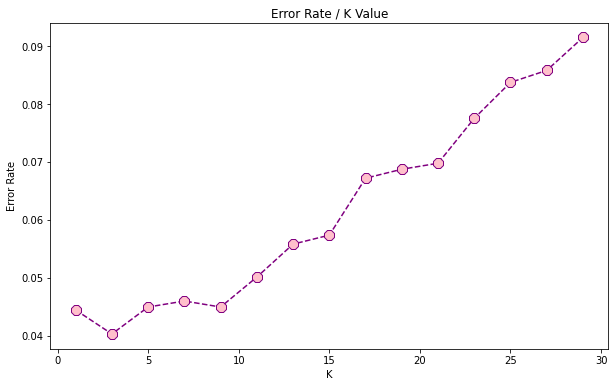

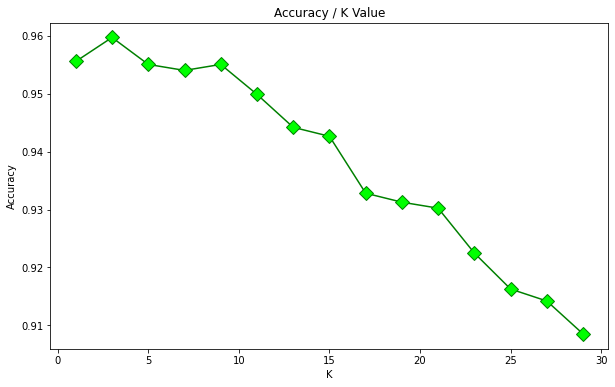

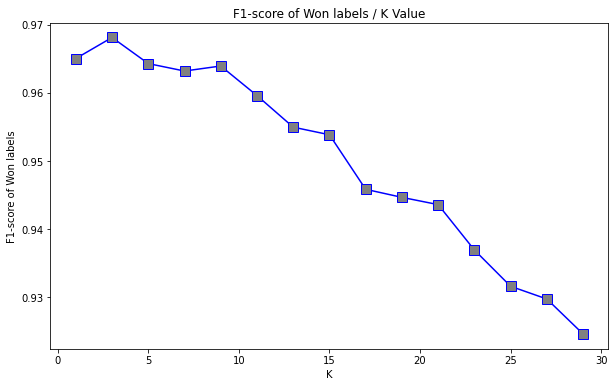

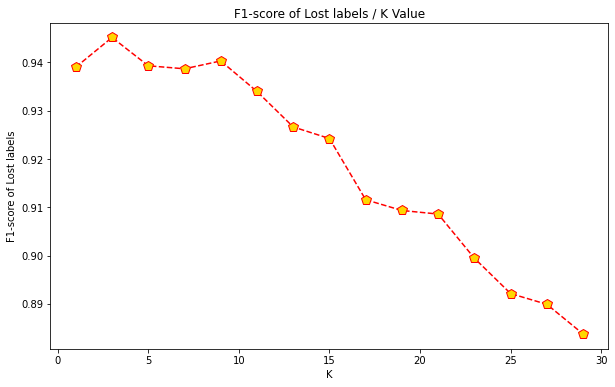

In [32]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

# Reading dataset
dataset = pd.read_excel('dataset.xlsx')

# Preprocess dataset to be used for classification
train_dataset, targets, in_progress_dataset = preprocess(dataset)

# Splitting preprocessed train dataset 30/70
X_train, X_test, y_train, y_test = train_test_split(train_dataset, targets, test_size=0.3, random_state=0)

# Find best value for K via plotting error rate, accuracy and f1-score of sklearn KNN on this dataset
error_rate = []
acc = []
f1_Won = []
f1_Lost = []
for i in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    predict = knn.predict(X_test)
    error_rate.append(np.mean(predict != y_test))
    acc.append(accuracy_score(y_test, predict))
    f1_Won.append(f1_score(y_test, predict, pos_label='Won'))
    f1_Lost.append(f1_score(y_test, predict, pos_label='Lost'))

# Error rate
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30, 2), error_rate, color='purple', linestyle='dashed',
         marker='8', markerfacecolor='pink', markersize=10)
plt.title('Error Rate / K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-", min(error_rate), "at K =", (error_rate.index(min(error_rate)) * 2) + 1)

# Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30, 2), acc, color='green', linestyle='solid',
         marker='D', markerfacecolor='lime', markersize=10)
plt.title('Accuracy / K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-", max(acc), "at K =", (acc.index(max(acc)) * 2) + 1)

# F1-score of Won
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30, 2), f1_Won, color='blue', linestyle='solid',
         marker='s', markerfacecolor='gray', markersize=10)
plt.title('F1-score of Won labels / K Value')
plt.xlabel('K')
plt.ylabel('F1-score of Won labels')
print("Maximum f1-score:-", max(f1_Won), "at K =", (f1_Won.index(max(f1_Won)) * 2) + 1)

# F1-score of Lost
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30, 2), f1_Lost, color='red', linestyle='dashed',
         marker='p', markerfacecolor='gold', markersize=10)
plt.title('F1-score of Lost labels / K Value')
plt.xlabel('K')
plt.ylabel('F1-score of Lost labels')
print("Maximum f1-score:-", max(f1_Lost), "at K =", (f1_Lost.index(max(f1_Lost)) * 2) + 1)


In [34]:
# Classifying data with our KNN classifier
clf = KNearestNeighbors(3)
clf.fit(X_train, y_train)
mypred = clf.predict(X_test)
mypred = np.array(mypred)

# classifying data with sklearn KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)
knn_pred = knn_classifier.predict(X_test)

# classifying data with sklearn Decision Tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_pred = dt_classifier.predict(X_test)


def classification_data_report(name, y_test_internal, pred_internal):
    """
    A function for reporting some analytical data about classification's performance
    :param name: classification model name
    :param y_test_internal: labels of test data
    :param pred_internal: predicted labels for test data
    :return: None
    """
    print('*** {} Classification Report ***'.format(name), end='\n\n')
    print('Confusion Matrix:\n', confusion_matrix(y_test_internal, pred_internal), end='\n\n')
    print('Classification Report:\n', classification_report(y_test_internal, pred_internal), end='\n\n')
    print('Accuracy:\n', accuracy_score(y_test_internal, pred_internal), end='\n\n')


# Printing classification statistics
classification_data_report('My KNN', y_test, mypred)
classification_data_report('sklearn KNN', y_test, knn_pred)
classification_data_report('sklearn DT', y_test, dt_pred)

*** My KNN Classification Report ***

Confusion Matrix:
 [[ 671   34]
 [  46 1184]]

Classification Report:
               precision    recall  f1-score   support

        Lost       0.94      0.95      0.94       705
         Won       0.97      0.96      0.97      1230

    accuracy                           0.96      1935
   macro avg       0.95      0.96      0.96      1935
weighted avg       0.96      0.96      0.96      1935


Accuracy:
 0.958656330749354

*** sklearn KNN Classification Report ***

Confusion Matrix:
 [[ 672   33]
 [  45 1185]]

Classification Report:
               precision    recall  f1-score   support

        Lost       0.94      0.95      0.95       705
         Won       0.97      0.96      0.97      1230

    accuracy                           0.96      1935
   macro avg       0.96      0.96      0.96      1935
weighted avg       0.96      0.96      0.96      1935


Accuracy:
 0.9596899224806201

*** sklearn DT Classification Report ***

Confusion Matrix:


In [36]:
# Predicting in-progress transactions results
clf.fit(train_dataset, targets)
predicted_data = clf.predict(in_progress_dataset)
in_progress_dataset['Deal_Stage'] = predicted_data
in_progress_dataset.to_csv('prediction.csv')